In [31]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jessicali9530_stanford_dogs_dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')

print('Data source import complete.')


Data source import complete.


In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Year 4 Uni/CNNDL'
!pwd
!unzip -o 'Dog Breed Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1357.jpg  
  inflating: images/Images/n02108089-boxer/n0210

In [ ]:
!pip install comet_ml --quiet
!pip install wandb --quiet

# !pip install ultralytics ray --quiet
!pip install --upgrade ray[tune] ultralytics
!pip install xmltodict --quiet

# !pip install ultralytics==8.0.196
# !pip install 'ray[tune]==2.7.1'

In [ ]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comet_ml
import wandb

from ultralytics import YOLO
import torch


import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml
import xmltodict



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
num_devices=1

if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    device = [i for i in range(num_devices)]
    device_name = torch.cuda.get_device_name()
elif torch.backends.mps.is_available():
    device = "mps"
    device_name = "mps"
else:
    device = "cpu"
    device_name = "cpu"


print(f"Using {device_name} as the Backend.")
print(f"Number of Devices: {num_devices}")

Using cpu as the Backend.
Number of Devices: 1


In [40]:
# Define dataset paths (Update these paths if needed)
ANNOTATIONS_PATH = pathlib.Path('/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annotations/Annotation')
IMAGES_PATH = pathlib.Path('/content/gdrive/MyDrive/Year 4 Uni/CNNDL/images/Images')

# Define root directory in Colab
ROOT_DIR = pathlib.Path("/content/")

# Define paths for saving processed data
NEW_DATA_PATH = ROOT_DIR / "data"
NEW_ANNOTATIONS_PATH = NEW_DATA_PATH / "annotations"
SLIDES_PATH = ROOT_DIR / "slides"

# Create necessary directories
os.makedirs(NEW_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(SLIDES_PATH, exist_ok=True)

# Change working directory
os.chdir(ROOT_DIR)

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Model & Dataset Config

In [ ]:
# Dataset
TEST_TRAIN_SPLIT = 0.15
VALIDATION_TRAIN_SPLIT = 0.15
# Model Vars
IMAGE_SIZE = 640
# Training
PROJECT_NAME = "dog_breed_detection"
DEVICE = device
BATCH_SIZE = 16
EPOCHS = 35  # 60 is too much, 1 epoch in training is about 10 minutes with P100 and defaults setting, kaggle session at most is 9 hours

## Dataset

### Convert Data to model Friendly Format

In [43]:
breed_dir_name = [
    breed
    for breed in sorted(os.listdir(IMAGES_PATH))
    if not breed.startswith(".") and os.path.isdir(IMAGES_PATH / breed)
]
print(f"Number of breeds: {len(breed_dir_name)}")
print(f"First 5 breeds: {breed_dir_name[:5]}")

Number of breeds: 120
First 5 breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']


In [44]:
# Initialize dataset DataFrame
dataset_df = pd.DataFrame(columns=["breed", "image_path", "annotation_path"])

# Iterate through each breed directory
for i, breed_dir in enumerate(breed_dir_name):
    breed_name = " ".join(breed_dir.replace("_", "-").split("-")[1:]).title()

    breed_images_dir_path = IMAGES_PATH / breed_dir
    breed_annotations_dir_path = ANNOTATIONS_PATH / breed_dir

    breed_images_name = [
        image
        for image in sorted(os.listdir(breed_images_dir_path))
        if not image.startswith(".") and image.endswith((".jpg", ".jpeg", ".png"))
    ]
    breed_annotations_name = [
        image.split(".")[0]
        for image in breed_images_name
    ]

    breed_images_path = [
        breed_images_dir_path / image
        for image in breed_images_name
        if os.path.isfile(breed_images_dir_path / image)
    ]
    breed_annotations_path = [
        breed_annotations_dir_path / annotation
        for annotation in breed_annotations_name
        if os.path.isfile(breed_annotations_dir_path / annotation)
    ]

    dataset_df = pd.concat([dataset_df, pd.DataFrame({
        "breed": breed_name,
        "image_path": breed_images_path,
        "annotation_path": breed_annotations_path
    })])

    if i % 10 == 0:
        print(f"Loading... {int(i / 1.20)}% done")

# Display first few rows
dataset_df.head()

Loading... 0% done
Loading... 8% done
Loading... 16% done
Loading... 25% done
Loading... 33% done
Loading... 41% done
Loading... 50% done
Loading... 58% done
Loading... 66% done
Loading... 75% done
Loading... 83% done
Loading... 91% done


,breed,image_path,annotation_path
0,Chihuahua,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
1,Chihuahua,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
2,Chihuahua,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
3,Chihuahua,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
4,Chihuahua,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...


In [45]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path']

(breed                                                      Chihuahua
 image_path         /content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...
 annotation_path    /content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
 Name: 0, dtype: object,
 PosixPath('/content/gdrive/MyDrive/Year 4 Uni/CNNDL/images/Images/n02085620-Chihuahua/n02085620_10074.jpg'),
 PosixPath('/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annotations/Annotation/n02085620-Chihuahua/n02085620_10074'))

In [46]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

print(read_txt(dataset_df.iloc[0]['annotation_path']))

<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [ ]:
# <annotation>
# 	<folder>02085620</folder>
# 	<filename>n02085620_10074</filename>
# 	<source>
# 		<database>ImageNet database</database>
# 	</source>
# 	<size>
# 		<width>333</width>
# 		<height>500</height>
# 		<depth>3</depth>
# 	</size>
# 	<segment>0</segment>
# 	<object>
# 		<name>Chihuahua</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>25</xmin>
# 			<ymin>10</ymin>
# 			<xmax>276</xmax>
# 			<ymax>498</ymax>
# 		</bndbox>
# 	</object>
# </annotation>



# <annotation>
# 	<folder>02085620</folder>
# 	<filename>n02085620_10131</filename>
# 	<source>
# 		<database>ImageNet database</database>
# 	</source>
# 	<size>
# 		<width>395</width>
# 		<height>495</height>
# 		<depth>3</depth>
# 	</size>
# 	<segment>0</segment>
# 	<object>
# 		<name>Chihuahua</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>49</xmin>
# 			<ymin>9</ymin>
# 			<xmax>393</xmax>
# 			<ymax>493</ymax>
# 		</bndbox>
# 	</object>
# </annotation>



In [47]:
dataset_df_path = NEW_DATA_PATH / "dataset_df.csv"
dataset_df = dataset_df.sort_values(by=["breed", "image_path"])
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = pd.read_csv(dataset_df_path)
dataset_df.head()

,breed,image_path,annotation_path
0,Affenpinscher,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
1,Affenpinscher,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
2,Affenpinscher,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
3,Affenpinscher,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
4,Affenpinscher,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...


In [48]:
import json

breeds = dataset_df["breed"].unique()
breeds_dict = {i: breed for i, breed in enumerate(breeds)}

breed_id_dict = {breed: i for i, breed in breeds_dict.items()}

breed_id_dict["Rottweiler"], breeds_dict[91]

(91, 'Rottweiler')

In [49]:
new_annotations = []
for i, annotation_path in enumerate(dataset_df["annotation_path"]):
    annotation_path = pathlib.Path(annotation_path)
    new_annotation_path = NEW_ANNOTATIONS_PATH / annotation_path.parent.name
    os.makedirs(new_annotation_path, exist_ok=True)
    annotation_name = annotation_path.name

    annotation_data = xmltodict.parse(annotation_path.read_text())
    image_w, image_h = (
        int(annotation_data["annotation"]["size"]["width"]),
        int(annotation_data["annotation"]["size"]["height"])
    )
    final_data = ""
    objects = annotation_data["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]

    for obj in objects:
        breed = obj["name"]
        xmin, ymin, xmax, ymax = (
            int(obj["bndbox"]["xmin"]),
            int(obj["bndbox"]["ymin"]),
            int(obj["bndbox"]["xmax"]),
            int(obj["bndbox"]["ymax"])
        )
        obj_h = ymax - ymin
        obj_w = xmax - xmin
        class_id = breed_id_dict[breed.replace("_", " ").replace("-", " ").title()]
        x, y, w, h = (
            (xmin + obj_w/2) / image_w,
            (ymin + obj_h/2) / image_h,
            (obj_w) /image_w ,
            (obj_h) / image_h
        )

        final_data += f"{class_id} {x} {y} {w} {h}\n"

    if i%2000==0:
        print(f"{i} done")
    new_annotation_path = new_annotation_path / (annotation_name+".txt")
    new_annotation_path.write_text(final_data)
    new_annotations.append(new_annotation_path)


0 done
2000 done
4000 done
6000 done
8000 done
10000 done
12000 done
14000 done
16000 done
18000 done
20000 done


In [50]:
dataset_df["new_annotation_path"] = new_annotations
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
dataset_df

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02111889-Samoyed/n0...
1,Borzoi,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02090622-borzoi/n02...
2,West Highland White Terrier,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02098286-West_Highl...
3,Basenji,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02110806-basenji/n0...
4,Weimaraner,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02092339-Weimaraner...
...,...,...,...,...
20575,Labrador Retriever,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02099712-Labrador_r...
20576,Lhasa,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02098413-Lhasa/n020...
20577,Chow,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02112137-chow/n0211...
20578,American Staffordshire Terrier,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02093428-American_S...


In [51]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path'], dataset_df.iloc[0]['new_annotation_path']

(breed                                                            Samoyed
 image_path             /content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...
 annotation_path        /content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...
 new_annotation_path    /content/data/annotations/n02111889-Samoyed/n0...
 Name: 0, dtype: object,
 '/content/gdrive/MyDrive/Year 4 Uni/CNNDL/images/Images/n02111889-Samoyed/n02111889_3345.jpg',
 '/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annotations/Annotation/n02111889-Samoyed/n02111889_3345',
 PosixPath('/content/data/annotations/n02111889-Samoyed/n02111889_3345.txt'))

In [52]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

read_txt(dataset_df.iloc[0]['new_annotation_path']), print(read_txt(dataset_df.iloc[0]['new_annotation_path']))

94 0.536 0.5746666666666667 0.924 0.7706666666666667



('94 0.536 0.5746666666666667 0.924 0.7706666666666667\n', None)

In [53]:
NEW_DATA_PATH,TEST_TRAIN_SPLIT

(PosixPath('/content/data'), 0.15)

In [54]:
test_split = TEST_TRAIN_SPLIT

test_df = dataset_df.sample(frac=test_split)
train_df = dataset_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df_path = NEW_DATA_PATH / "train_df.csv"
test_df_path = NEW_DATA_PATH / "test_df.csv"

train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

val_split = VALIDATION_TRAIN_SPLIT
val_df = train_df.sample(frac=val_split)
train_df = train_df.drop(val_df.index)

a,b,c = len(train_df), len(val_df), len(test_df)

print(f"Train set has {a} images")
print(f"Validation set has {b} images")
print(f"Test set has {c} images")

Train set has 14869 images
Validation set has 2624 images
Test set has 3087 images


In [55]:
train_dir = NEW_DATA_PATH / "train"
val_dir = NEW_DATA_PATH / "val"
test_dir = NEW_DATA_PATH / "test"

In [56]:
try:

    for image_path, label_path in zip(train_df["image_path"], train_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = train_dir / "images"
        labels_dir_path = train_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)

        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(val_df["image_path"], val_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = val_dir / "images"
        labels_dir_path = val_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)

        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(test_df["image_path"], test_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = test_dir / "images"
        labels_dir_path = test_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)

        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

except FileExistsError:
    pass

In [57]:
breeds_dict

{0: 'Affenpinscher',
 1: 'Afghan Hound',
 2: 'African Hunting Dog',
 3: 'Airedale',
 4: 'American Staffordshire Terrier',
 5: 'Appenzeller',
 6: 'Australian Terrier',
 7: 'Basenji',
 8: 'Basset',
 9: 'Beagle',
 10: 'Bedlington Terrier',
 11: 'Bernese Mountain Dog',
 12: 'Black And Tan Coonhound',
 13: 'Blenheim Spaniel',
 14: 'Bloodhound',
 15: 'Bluetick',
 16: 'Border Collie',
 17: 'Border Terrier',
 18: 'Borzoi',
 19: 'Boston Bull',
 20: 'Bouvier Des Flandres',
 21: 'Boxer',
 22: 'Brabancon Griffon',
 23: 'Briard',
 24: 'Brittany Spaniel',
 25: 'Bull Mastiff',
 26: 'Cairn',
 27: 'Cardigan',
 28: 'Chesapeake Bay Retriever',
 29: 'Chihuahua',
 30: 'Chow',
 31: 'Clumber',
 32: 'Cocker Spaniel',
 33: 'Collie',
 34: 'Curly Coated Retriever',
 35: 'Dandie Dinmont',
 36: 'Dhole',
 37: 'Dingo',
 38: 'Doberman',
 39: 'English Foxhound',
 40: 'English Setter',
 41: 'English Springer',
 42: 'Entlebucher',
 43: 'Eskimo Dog',
 44: 'Flat Coated Retriever',
 45: 'French Bulldog',
 46: 'German Sheph

In [58]:
import yaml
dataset_details = {
    "path": str(NEW_DATA_PATH),
    "train": "train",
    "val": "val",
    "test": "test",

    "names": breeds_dict
}

dataset_yaml_path = ROOT_DIR / "detection/dataset.yaml"
os.makedirs(dataset_yaml_path.parent, exist_ok=True)

with open(dataset_yaml_path, "w") as f:
    yaml.dump(dataset_details, f, default_flow_style=False)

CLASS_NAMES = list(breeds_dict.values())
NUM_CLASSES = len(CLASS_NAMES)

In [59]:
NUM_CLASSES, CLASS_NAMES

(120,
 ['Affenpinscher',
  'Afghan Hound',
  'African Hunting Dog',
  'Airedale',
  'American Staffordshire Terrier',
  'Appenzeller',
  'Australian Terrier',
  'Basenji',
  'Basset',
  'Beagle',
  'Bedlington Terrier',
  'Bernese Mountain Dog',
  'Black And Tan Coonhound',
  'Blenheim Spaniel',
  'Bloodhound',
  'Bluetick',
  'Border Collie',
  'Border Terrier',
  'Borzoi',
  'Boston Bull',
  'Bouvier Des Flandres',
  'Boxer',
  'Brabancon Griffon',
  'Briard',
  'Brittany Spaniel',
  'Bull Mastiff',
  'Cairn',
  'Cardigan',
  'Chesapeake Bay Retriever',
  'Chihuahua',
  'Chow',
  'Clumber',
  'Cocker Spaniel',
  'Collie',
  'Curly Coated Retriever',
  'Dandie Dinmont',
  'Dhole',
  'Dingo',
  'Doberman',
  'English Foxhound',
  'English Setter',
  'English Springer',
  'Entlebucher',
  'Eskimo Dog',
  'Flat Coated Retriever',
  'French Bulldog',
  'German Shepherd',
  'German Short Haired Pointer',
  'Giant Schnauzer',
  'Golden Retriever',
  'Gordon Setter',
  'Great Dane',
  'Great

### Data Visualization

In [60]:
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02111889-Samoyed/n0...
1,Borzoi,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02090622-borzoi/n02...
2,West Highland White Terrier,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02098286-West_Highl...
3,Basenji,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02110806-basenji/n0...
4,Weimaraner,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/image...,/content/gdrive/MyDrive/Year 4 Uni/CNNDL/annot...,/content/data/annotations/n02092339-Weimaraner...


#### Helper Functions

In [61]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image,
    boxes: list[float],
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int

    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255

    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape

    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )

        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)

        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]

        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)

            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv,
                cls_name,
                text_position,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                2,
                cv2.LINE_AA,
                False,
            )

    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    return image


In [62]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label

    show_image()



In [63]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()

    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)

    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[32], [54], [41, 41], [113], [41], [47], [4], [103]]

In [64]:
len(images)

8

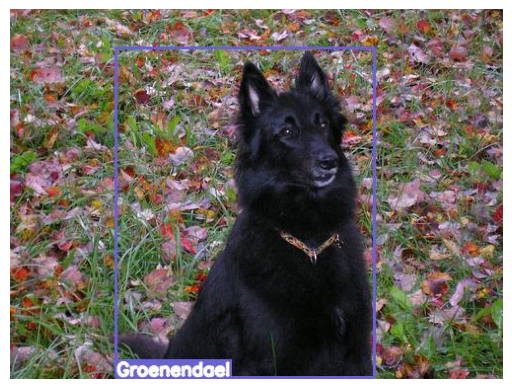

In [67]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [68]:
!pip uninstall ultralytics ray -y
!pip install ultralytics
!pip install 'ray[tune]'

# Found existing installation: ultralytics 8.3.58
# Uninstalling ultralytics-8.3.58:
#   Successfully uninstalled ultralytics-8.3.58
# Found existing installation: ray 2.4.0
# Uninstalling ray-2.4.0:
#   Successfully uninstalled ray-2.4.0

# ray-2.40.0-cp310-cp310-manylinux2014_x86_64.whl
# Successfully installed ray-2.40.0

Found existing installation: ultralytics 8.3.95
Uninstalling ultralytics-8.3.95:
  Successfully uninstalled ultralytics-8.3.95
Found existing installation: ray 2.44.0
Uninstalling ray-2.44.0:
  Successfully uninstalled ray-2.44.0
  Using cached ultralytics-8.3.95-py3-none-any.whl.metadata (35 kB)
Using cached ultralytics-8.3.95-py3-none-any.whl (949 kB)


  Using cached ray-2.44.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (19 kB)
Using cached ray-2.44.0-cp311-cp311-manylinux2014_x86_64.whl (68.1 MB)


In [69]:
pip list | grep ultralytics

ultralytics                        8.3.95
ultralytics-thop                   2.0.14


In [70]:
!pip install --upgrade ray

In [ ]:
# from ultralytics.utils.callbacks.raytune import on_fit_epoch_end

EPOCHS = 35

model_name = "yolov12n.pt"
version = "v1.0"
experiment_name = f"{model_name}-{version}"
# save_dir = f"runs/train/{projext_name}"
resume = False

if resume:
    pass
    # weight = f"{save_dir}/weights/last.pt"
    # model = YOLO(weight)
    # model.train(resume=True)

else:
    model = YOLO('/content/gdrive/MyDrive/Year 4 Uni/CNNDL/yolov12n.pt')

    # 移除 Ray Tune 回调
    # model.add_callback("on_fit_epoch_end", on_fit_epoch_end, remove=True)

    model.train(
        data=dataset_yaml_path,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        device=DEVICE,
        project=PROJECT_NAME,

        name=experiment_name,

        exist_ok=True,
        patience = 15,
        save_period=5
        )


Ultralytics 8.3.95 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/gdrive/MyDrive/Year 4 Uni/CNNDL/yolov12n.pt, data=/content/detection/dataset.yaml, epochs=35, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cpu, workers=8, project=dog_breed_detection, name=yolov12n.pt-v1.0, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]


Overriding model.yaml nc=80 with nc=120

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralyti

COMET ERROR: Failed to create Comet experiment, reason: ValueError('Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY ')


WARNING ⚠️ Comet installed but not initialized correctly, not logging this run. Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
TensorBoard: Start with 'tensorboard --logdir dog_breed_detection/yolov12n.pt-v1.0', view at http://localhost:6006/
Freezing layer 'model.21.dfl.conv.weight'


train: Scanning /content/data/train/labels... 14869 images, 0 backgrounds, 1 corrupt: 100%|██████████| 14869/14869 [02:25<00:00, 101.92it/s]

train: WARNING ⚠️ /content/data/train/images/n02089973_1763.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/n02089973_2054.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/n02106030_3948.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0278]


train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 2624 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2624/2624 [00:32<00:00, 80.75it/s] 


val: New cache created: /content/data/val/labels.cache
Plotting labels to dog_breed_detection/yolov12n.pt-v1.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.1e-05, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to dog_breed_detection/yolov12n.pt-v1.0
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35         0G      1.372      5.187      1.805         43        640:  14%|█▎        | 126/930 [51:15<5:31:08, 24.71s/it]

In [ ]:
model_weight = "/kaggle/working/dog_breed_detection/yolov8m-v1/weights/last.pt"
model = model = YOLO(model_weight)
model.train(
    box=1,
    cls=2.5,
    dfl=5,
    resume=True
)


In [ ]:
model_weight = "/kaggle/working/dog_breed_detection/yolov8m-v1/weights/last.pt"
model = model = YOLO(model_weight)
model.train(
    box=1,
    cls=5,
    dfl=8,
    resume=True
)